In [1]:
#default_exp ensemble

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Dev comments

Project definitions:

- Set a method called dfit or overwrite fit method in order to have sklearn pipeline support?
- Delegates for an instance of estimator inside class or increment classes through factories (better support in sklearn pipelines)?


- [X] TODO: Solve Tree Predict mistery
- [ ] TODO: make meta bagged randomized prior class
- [X] TODO: make a multivariate joint dist estimator for AdaBoostingRegressor

- [X] TODO: make boosting and baging tree estimator classes
- [X] TODO: implement bagging and boosting meta estimator (include sampling from sub models)
- [X] TODO: include target scaling in pipeline
- [ ] TODO: Create DensityEstimator Base Class containing sample and density methods (density calls sample and returns RV CLASS)
- [ ] TODO: Mean, Variance and Entropy explainer tool (LIME, SHAP, foressts...)
- [X] TODO: Decide wether to allow multi output (doesnt model well multivariate bimodal joint probabilities, cheeky to sample (two different random samples))
- [X] Entropy based regression with random forest embeddings + entropy of targets in each node
- [X] enhance multioutput estimator class
- [X] make possible for user defined sample weights for y_ in self.sample(allow time exponential decay sampling, for example) WE MAY GET THE DISTRIBUTION FOR FREE WITH self.proba_preds

- [X] Make EntropyEstimator class to handle any estimator turning regression problem into a classification one
- [X] fix resolution to any number of bins
- [X] Make EntropyEstimator Ensemble (Bagging and Boosting) - Came for free with BaggingClassifier (predict_proba)
- [ ] Make _ChainedJointEstimator, define joint estimation strategy, maybe using mu
- [X] Update EntropyEstimator sampling method encompassing KDE sampling
- [ ] Incorporate _ChainedJointEstimator on MultiOutputEntropyEstimator
- [ ] Reorganize 01_ensemble in 01_entropy_estimator, 02_joint_estimator and 03_ensemble_estimator
- [X] Change name of MultiOutputEtimator to JointOutputEstimtor
- [ ] Make cov_add_noise in estimators (not needed for kde since data is whitened with PCA)

- [ ] Make chained/stacked estimator (good for time series) (creates a new feature-as the predicted bin for each estim)
    make parallel (with kernel tree) and sequential estimators (timeseries vs joint)
- [ ] Make quantile calibration of probability densisties (to make it uniform)
- [X] Make Probability calibrations for entropy estimation

# Imports -

In [4]:
#export
from warnings import warn
from functools import partial
import copy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.utils.fixes import _joblib_parallel_args
from sklearn.metrics import pairwise
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from numpy.linalg import LinAlgError
from scipy.spatial.distance import cdist

import scipy
from joblib import Parallel, delayed


from skdensity.utils import (cos_sim_query, sample_multi_dim, ctqdm, add_noise,sample_from_dist_array,
                                  DelegateEstimatorMixIn, _fix_X_1d, _fix_one_dist_1d, _fix_one_dist_2d,
                                  _add_n_dists_axis,_add_n_samples_axis,_add_n_dims_axis,sample_idxs
                                 )

from skdensity.metrics import kde_entropy, quantile, marginal_variance, bimodal_variance, kde_likelihood, kde_quantile, agg_smallest_distance, cdf
from skdensity.core.random_variable import KDE, RandomVariable, RVArray

# Ensemble density estimators -

Density estimators based on ensemble methods, such as baging, boosting and some decision tree algorithms. All 'classes' are actually factories that dinamically extends the funcitonality of the original sklearn class with methods such as sample.

# Example data

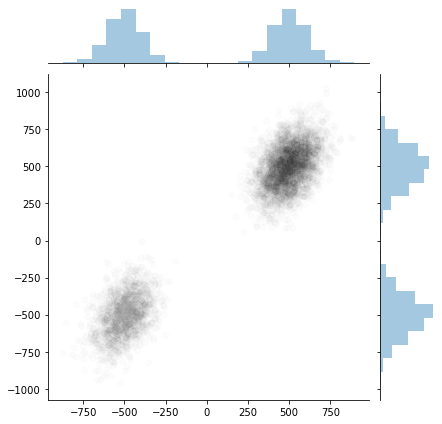

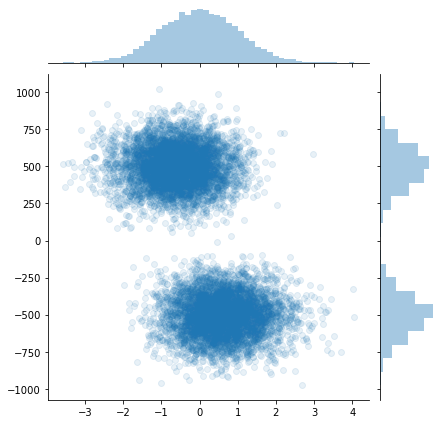

In [5]:
import seaborn as sns
from sklearn.datasets import make_regression
from matplotlib import cm

def sigmoid(x):
    return 1/(1+np.exp(x))

X,y = make_regression(
    n_samples=10000,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=5,
    noise=1,
    shuffle=True,
    coef=False,
    random_state=None
)


#make one of X[1] feature mode weightening
bimodal_factor_wieght = 2
bimodal_factors = (sigmoid(bimodal_factor_wieght*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
bimodal_factors[bimodal_factors == 0] = -1
bimodal_factors = bimodal_factors.reshape(-1,1)

y = bimodal_factors*y

colors = cm.get_cmap('binary')(256*(sigmoid(bimodal_factor_wieght*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int))

sns.jointplot(y[:,0],y[:,1], joint_kws = {'color': colors}, alpha = 0.01)

sns.jointplot(X[:,-1], y[:,1], alpha = 0.1)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):]

# QuantileCalibrator
> A class to calibrates samples in order to bring the quantile distribution closer to a uniform distribution

In [6]:
#export
class QuantileCalibrator(BaseEstimator):

    def __init__(self, estimator, bins = 100):

        self.estimator = estimator
        self.bins = bins
        return

    def fit(self, X, y, **sampling_kws):
        '''
        X are the samples from the trainning set
        y is the true value, alligned with its respective distribution (X)
        '''
        samples = self.estimator.sample(X, **sampling_kws)
        q_x = quantile(y, samples)

        q_dist, _ = np.histogram(q_x, bins=self.bins, range=[0,1], weights=None, density=False)

        #fill zeros with 1 to avoid problems in division
        q_dist = np.where(q_dist == 0, 1, q_dist)

        self.q_dist = q_dist
        return self

    def _make_resampling_weights(self, X):
        '''
        define new sampling wieghts for each set of samples
        '''
        cdfs = cdf(X)
        cdfs = cdfs[:,:,0] #works only for 1d dists
        weights = []
        for dist in cdfs:
            dg = np.digitize(dist, bins=np.linspace(0,1,self.bins-1, endpoint = False))
            weights.append(self.q_dist[dg])

        #create weights as the bin count and then normalize
        weights = normalize(np.array(weights), norm = 'l1')
        return weights

    def sample(self, X, sample_size = 100, weight_func = None,
               alpha = None, replace = True, noise_factor = 0, **sampling_kws):
        '''
        resamples values in each dist taking into account quantile calibration factor learned from
        training set
        '''

        X = self.estimator.sample(X, sample_size = 100, weight_func = None,
               alpha = None, replace = True, noise_factor = 0, **sampling_kws)

        p = self._make_resampling_weights(X)
        samples = sample_from_dist_array(X, sample_size, weights = p)
        noise = agg_smallest_distance(samples, agg_func = np.std)
        noise = _add_n_dims_axis(noise)
        return add_noise(samples, noise_factor*noise)

# EntropyEstimator
> An estimator that performas a classification on a discretized transformation of a continuous space using QuantileTransformer, predicts a probability distribution using proba_preds and maps back to continuous domain.
Base estimator can be any estimator that performs predict_proba method.

In [7]:
#export

def identity_func(x):
    return x

IDENTITY_TRANSFORMER = FunctionTransformer(
    func = identity_func,
    inverse_func = identity_func,
    validate=False,
    accept_sparse=True,
    check_inverse=True,
    kw_args=None,
    inv_kw_args=None,
)


class EntropyEstimator(BaseEstimator, DelegateEstimatorMixIn):
    '''
    Meanwhile only performs marginal density estiamtion, not joint. Thus, only 1dimensional y.
    For joint, should try something using RegressionChain (to pass dimension information to the prediction of other dims)
    '''
    def __init__(self,estimator, resolution = 100, alpha = 1, calibrated_classifier = None, calibration_cv = 4,rv_bins_kws = {}):
        '''
        resolution can be int (number of bins of uniform quantile transformation) or hist array
        '''
        assert hasattr(estimator, 'predict_proba'), 'estimator should implement `predict_proba` method'
        self.estimator = estimator
        
        self.alpha = alpha
        assert isinstance(resolution, (np.ndarray, int, str)), f'resolution should be Array of bin edges, str or int, got {resolution.__class__}'
        self.resolution = resolution
        self.rv_bins_kws = rv_bins_kws        

        self.calibration_cv = calibration_cv
        if calibrated_classifier == 'default':
            self.calibrated_classifier = CalibratedClassifierCV(base_estimator=self.estimator, method='isotonic', cv = calibration_cv, ensemble = False)
        elif calibrated_classifier is None:
            self.calibrated_classifier = None
        else:
            assert hasattr(calibrated_classifier, 'predict_proba'), f'calibrated_classifier should implement `predict_proba method`'
            assert not isinstance(calibrated_classifier, type), f'calibrated_classifier should be an instance, not type'
            self.calibrated_classifier = calibrated_classifier

        return

    def _q_transformer_fit(self, y):
        '''
        fits self.q_transformer
        '''
        y = _fix_X_1d(y)
        if type(self.resolution) == str:
            self.bin_edges = np.histogram_bin_edges(y, bins = self.resolution)
            return self.bin_edges
        
        elif type(self.resolution) == int:
            self.q_transformer = QuantileTransformer(n_quantiles = self.resolution)
            self._q_minmax_scaler = MinMaxScaler()            
            y = self.q_transformer.fit_transform(y)
            #for case when output_distribution != uniform
            self._q_minmax_scaler.fit(y)
            return self.q_transformer
        
        elif isinstance(self.resolution,np.ndarray):
            return self.resolution
        
        else: raise TypeError(f'self.resolution should be Array of bin edges, str or int, got {self.resolution.__class__}')
        
        

    def _q_transformer_transform(self, y):
        '''
        maps floats to int (bin_id in histogram)
        '''
        y = _fix_X_1d(y)
        
        if type(self.resolution) == str:
            y_transformed = np.digitize(y, self.bin_edges)
            
        elif type(self.resolution) == int:
            y_transformed = self.q_transformer.transform(y)
            #scale between 0 and 1
            y_transformed = self._q_minmax_scaler.transform(y_transformed)
            y_transformed = np.around(y_transformed*(self.resolution - 1), decimals = 0).astype(int)
        
        elif isinstance(self.resolution,np.ndarray):
            y_transformed = np.digitize(y, self.resolution)
        
        return y_transformed.flatten()

    def _q_transformer_inverse_transform(self,y):
        '''
        maps from bin_id in histogram (int) to float.
        beware that during transform, information is lost due to downsampling, so inverse_transform will
        not be an exact inverse_transform.
        '''
        y = _fix_X_1d(y)
        if type(self.resolution) == int:
            y_transformed = (y/(self.resolution - 1)).astype(float)
            y_transformed = self._q_minmax_scaler.inverse_transform(y_transformed)
            return self.q_transformer.inverse_transform(y_transformed).flatten() #1d asserted already
        else: raise NotImplementedError('inverse transform only implemented for case when self.resolution == int')

    def _preprocess_y_fit(self, y):
        #set y_dim
        if len(y.shape) == 1:
            self.y_dim = 1
        elif len(y.shape) == 2:
            # assert 1d
            assert y.shape[-1] == 1, 'y should be 1d. For joint estimation use KernelTreeEntropyEstimator or JointEntropyEstimator'
            self.y_dim = y.shape[-1]
        else:
            raise AssertionError('y should be 1d vector or 2d column array (n_samples,1)')
        #reshape when y.dim == 1 and array dim equals 2
        if self.y_dim == 1:
            y = y.reshape(y.shape[0])
        self._q_transformer_fit(y)
        return self

    def _preprocess_y_transform(self, y):
        #set y_dim
        if len(y.shape) == 1:
            self.y_dim = 1
        elif len(y.shape) == 2:
            # assert 1d
            assert y.shape[-1] == 1, 'y should be 1d. For joint estimation use KernelTreeEntropyEstimator or JointEntropyEstimator'
            self.y_dim = y.shape[-1]
        else:
            raise AssertionError('y should be 1d vector or 2d column array (n_samples,1)')
        #reshape when y.dim == 1 and array dim equals 2
        if self.y_dim == 1:
            y = y.reshape(y.shape[0])
        # Fit one instance of RandomVariable or KDE for each bin:
        y_transformed = self._q_transformer_transform(y)
        return y_transformed

    def _preprocess_y_fit_transform(self, y):
        self._preprocess_y_fit(y)
        return self._preprocess_y_transform(y)

    def fit(self, X, y = None, **estimator_fit_kws):
        #fit y transformer
        self._preprocess_y_fit(y)
        #transform y
        y_transformed = self._preprocess_y_transform(y)
        # fit kdes
        bin_ids = list(set(y_transformed))
        bins_data_mapper = [y[y_transformed == i] for i in bin_ids]
        self._bin_dist_rvs = [RandomVariable(**self.rv_bins_kws).fit(d) for d in bins_data_mapper]

        #fit calibrated classifier
        if not self.calibrated_classifier is None:
            self.calibrated_classifier.fit(X = X, y = y_transformed, **estimator_fit_kws)
            self.estimator = self.calibrated_classifier.calibrated_classifiers_[0].base_estimator
        else:
            #fit classifier
            self.estimator.fit(X = X, y = y_transformed, **estimator_fit_kws)

        return self

    def _get_bin_pdf(self,X):
        '''
        returns pdf array of shape (n_dists, n_bins, n_dims)
        the values are the probability "density" for that bin
        '''
        if not self.calibrated_classifier is None:
            probas = self.calibrated_classifier.predict_proba(X)
            probas = np.array(probas)
            return np.array(probas)
        else:
            probas = self.estimator.predict_proba(X)
            return np.array(probas)

    def custom_predict(self, X, agg_func = np.mean, sample_size = 100, weight_func = None, alpha = None, replace = True, noise_factor = 0):
        '''
        performs aggregation in a samples drawn for a specific X and returns the custom predicted value
        as the result of the aggregation. Could be mean, mode, median, std, entropy, likelihood...
        note that agg_func recieves an array of shape (n_samples, n_dims). If you want to perform
        aggregation along dimensions, dont forget to tell agg_func to perform operations along axis = 0
        '''

        samples = self.sample(X, sample_size, weight_func, alpha, replace, noise_factor)
        return np.array([agg_func(sample) for sample in samples])


    def _rv_bin_sample(self, bin_probas, sample_size):
        '''
        Generate RV samples from bins of 1 observation
        '''
        assert len(bin_probas.shape) == 2, f'Passed weights array should be 2d not {bin_probas.shape}'
        #sample_sizes = np.round(sample_size*weights_array,0)
        #delta_sample_sizes = sample_size - sample_sizes.sum(axis = 0)
        # make sample_sizes sum up to sample_size <- there might be a better way to do it
        #assert delta_sample_sizes >= 0, 'sample_size sanity check not passed, delta negative'
        #if delta_sample_sizes > 0:
        #    idxs = sample_idxs(weights_array, sample_size = delta_sample_sizes)
        #    idxs, counts = numpy.unique(a, return_counts=True)
        #    for i in range(idxs.shape[0]):
        #        sample_sizes[idxs[i]] += counts[i]
        #SAMPLE ALL KDES AND THE SAMPLE FROM SAMPLED ARRAY
        samples_dist = np.array([bin_dist.sample(sample_size) for bin_dist in self._bin_dist_rvs])
        
        samples_dist = _add_n_dims_axis(samples_dist)
        samples_dist = samples_dist[:,:,0]
        idxs = sample_idxs(bin_probas, sample_size = sample_size)
        samples = []
        for i in tqdm(np.arange(bin_probas.shape[0])):
            idx = idxs[i]
            idx, counts = np.unique(idx, return_counts = True)
            s = [np.random.choice(samples_dist[i],c, replace = True) for i,c in zip(idx,counts)]
            #s = [self._bin_dist_rvs[vc[0]].rvs(sample_size = vc[1]).flatten() for vc in value_counts]

            samples.append(np.concatenate(s))
            #samples.append(np.concatenate(s))
        return np.array(samples)

    def sample(self, X, sample_size = 100, weight_func = None, alpha = None, replace = True, noise_factor = 0):
        '''
        weight func is a function that takes weight array (n_dists, n_bins) and returned
        an array of the same shape but with desired processing of the weights. if weight_func is not None,
        alpha is ignored
        '''
        #set alpha if not None, else use self.alpha
        alpha = alpha if not alpha is None else self.alpha

        #apply weight_func if not None, else, power to alpha
        bins_probas = self._get_bin_pdf(X)

        if self.y_dim == 1:
            bins_probas = _add_n_dists_axis(bins_probas)

        bins_probas = _fix_X_1d(bins_probas)
        # for 1d case
        bins_probas = bins_probas[0,:,:]
        if not weight_func is None:
            bins_probas = normalize(weight_func(bins_probas), norm  = 'l1')
        else:
            bins_probas = normalize(bins_probas**alpha, norm = 'l1')

        #samples = []
        #for dim_dist in bins_probas:
        #    dim_dist = _fix_X_1d(dim_dist)
        #    if not weight_func is None:
        #        bin_probas = normalize(weight_func(dim_dist), norm  = 'l1')
        #    else:
        #        bin_probas = normalize(dim_dist**alpha, norm = 'l1')

        #    sampled_bins = sample_idxs(bin_probas, sample_size, replace)
            #reshape in order to work with the QuantileTransformer inverse_transform foe each iteration
            #sampled_bins = sampled_bins.reshape(*sampled_bins.shape, 1)
            #samples.append(sampled_bins)

        #samples = np.array([self._q_transformer_inverse_transform(sb) for sb in samples])
        #samples = np.array(samples)
        #samples = np.moveaxis(samples, 2,1)
        #samples = np.moveaxis(samples, 0,2)

        #samples = np.array([self._q_transformer_inverse_transform(s) for s in samples])
        samples = self._rv_bin_sample(bins_probas, sample_size)
        samples = _add_n_dims_axis(samples) # make a 3d sample array with dim axis = 1
        noise = agg_smallest_distance(samples, agg_func = np.std)
        noise = _add_n_dims_axis(noise)
        return add_noise(samples, noise_factor*noise)

    def density(self, X, dist = 'kde', sample_size = 100, weight_func = None, alpha = None, replace = True, noise_factor = 1e-7, **dist_kws):
        '''
        returns a RVArray instance of RandomVariable objects fitted on sampled data based on X and other sample params
        '''
        samples = self.sample(X, sample_size, weight_func, alpha, replace, noise_factor)
        rv_objects = [RandomVariable(keep_samples = False).fit(sample, dist, **dist_kws) for sample in tqdm(samples)]
        return RVArray(rv_objects)
        
    
    def score(self, X, y = None, **score_kws):
        return self.estimator.score(X, self._q_transformer_transform(y), **score_kws)

`EntropyEstimator` turns the regression problem into a classification one, predicts the expected bins and the turns it back to continuous domain.
It accepts any estimator with the `predict_proba` method as a base estimator.

It works well for any kind of distribution, but only supports marginal distribution estimation

In [8]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

estim1 = EntropyEstimator(LogisticRegression(tol = 0.001, solver = 'sag'), 'auto', rv_bins_kws = {'default_dist':'norm'})
estim2 = EntropyEstimator(LogisticRegression(tol = 0.001, solver = 'sag'), 30, rv_bins_kws = {'default_dist':['norm','lognorm','cauchy']})
estim1.fit(X_train, y_train[:,1])
estim2.fit(X_train, y_train[:,1])

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


EntropyEstimator(estimator=LogisticRegression(solver='sag', tol=0.001),
                 resolution=30,
                 rv_bins_kws={'default_dist': ['norm', 'lognorm', 'cauchy']})

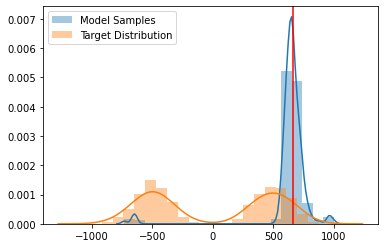

In [9]:
i = np.random.choice(np.arange(y_test.shape[0]))

alpha = 1
noise_factor = 0.2

samples2 = estim2.sample(X_test[i:i+1], sample_size = 200, alpha = alpha, noise_factor = noise_factor)
#prediction = density_estimator1.custom_predict(
#    X_test[i:i+1], agg_func = lambda x: np.mean(x,axis = 0), alpha = alpha, beta = beta, gamma = gamma)
#naive_prediction = density_estimator1.predict(X_test[i:i+1])

if (len(samples2.shape) > 1) and (samples2.shape[-1] == 2):
    jntplot = sns.jointplot(samples2[0,:,0], samples2[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    dst = sns.distplot(samples2, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test[:,1], kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

In [10]:
alpha = 1
noise_factor = 0.0
samples1 = estim1.sample(X_test, 1000, alpha = alpha, noise_factor = noise_factor)
samples2 = estim2.sample(X_test, 1000, alpha = alpha, noise_factor = noise_factor)

0.6277152332651388 0.9594277149470818


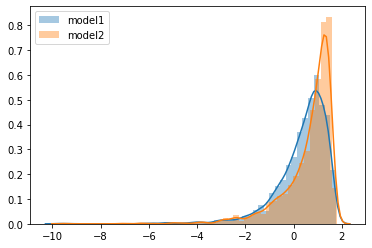

In [11]:
ll1 = np.log2(kde_likelihood(y_test[:,1:2],samples1))
ll2 = np.log2(kde_likelihood(y_test[:,1:2],samples2))
sns.distplot(ll1[ll1 > -30], label = 'model1')
sns.distplot(ll2[ll2 > -30], label = 'model2')
plt.legend()
print(np.median(ll1[ll1 > -1e10]), np.median(ll2[ll2 > -1e10]))

0.15537303579496434 0.0029742018284517192


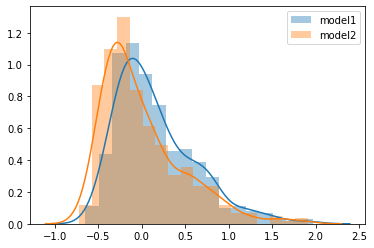

In [12]:
entr1 = kde_entropy(samples1, frac = 0.2,sample_size = 100)
entr2 = kde_entropy(samples2, frac = 0.2,sample_size = 100)
sns.distplot(entr1, label = 'model1')
sns.distplot(entr2, label = 'model2')
plt.legend()
print(entr1.mean(),entr2.mean())


In [13]:
q2 = quantile(y_test[:,1],samples2)
q1 = quantile(y_test[:,1],samples1)

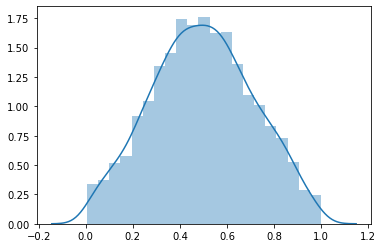

In [14]:
sns.distplot(q1)

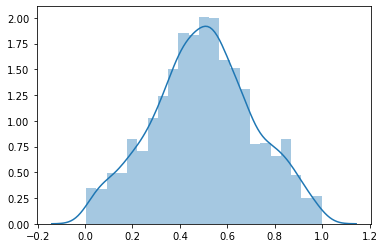

In [15]:
sns.distplot(q2)

# Ensemble Tree methods

## TreeEstimatorMixin class
>creates some functionalities for similarity sampling based random forests and naive sampling random forests

In [16]:
#export
#node quality functions
def expected_likelihood(node_data, sample_size = 100):
    kde = KDE().fit(node_data)
    return np.mean(kde.evaluate(kde.rvs(size = sample_size)))

def inverese_log_node_var(node_data):  #makes no sense for multivariate distribtuions
    centroid = node_data.mean(axis = 0).reshape(1,-1)
    distances =  cdist(node_data, centroid, 'seuclidean').flatten()
    return 1/np.log1p(np.mean(distances))


# datapoint-node functions
def datapoint_pdf(node_data):
    return KDE().fit(node_data).pdf(node_data)

def datapoint_gaussian_likelihood(node_data):
    centroid = node_data.mean(axis = 0).reshape(1,-1)
    distances =  cdist(node_data, centroid, 'seuclidean').flatten()
    distance_std = distances.std()
    #if distance_std == 0:
    #    return 1
    z = (distances - distances.mean())/distance_std
    return 1/(distance_std*np.pi**(1/2))*np.exp(-1/2*z**2)

def _bimodal_variance_fix_dim(x):
    if len(x.shape) == 1:
        return 1/np.log1p(bimodal_variance(_fix_one_dist_1d(x)))
    else:
        return 1/np.log1p(bimodal_variance(_fix_one_dist_2d(x)))


AVALIBLE_NODE_AGG_FUNC = {
    'expected_likelihood':expected_likelihood,
    'inverse_log_variance':inverese_log_node_var,
    'inverse_log_bimodal_variance': _bimodal_variance_fix_dim
}

AVALIBLE_DATAPOINT_WEIGHT_FUNC = {
    'kde_likelihood': datapoint_pdf,
    'gaussian_likelihood': datapoint_gaussian_likelihood
}

In [17]:
#export
class TreeEstimatorMixin():

    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''

    @property
    def _node_data_generator(self):
        return self._make_node_data_generator(self.y_, self._raw_leaf_node_matrix)

    def _make_node_data_generator(self, y, node_matrix):
        '''
        creates a generator from sparse matrix where each iter retrns a row
        '''
        s1 = node_matrix.sum(axis = 0).cumsum().A.astype(int).flatten()
        s2 = np.concatenate([[0],s1[:-1]])
        slices = [slice(i[0],i[1]) for i in zip(s2,s1)]
        idxs = node_matrix.tocsc().indices
        idxs = [idxs[s] for s in slices]
        return (y[idx] for idx in tqdm(idxs))
    
    def _make_node_kde_array(self): #<- since kde esitmation is the best approach, save kde fitted instances for each node
        #to make use of it during node and node_data wieght inference
        #maybe its better to get data from multiple nodes before fitting kde
        raise NotImplementedError

    def _make_node_cdist_array(self): #<- gaussian likelihood works fine as well, so save cdist matrix for each node
        raise NotImplementedError

    def _apply(self, X):
        '''
        A substitute for estimator.apply in case it returns 3d arrays (such as sklearns gradient boosting classifier)
        instead of 2d. In case returned array from estimator.apply returns a 2dim array, the returned value of the function
        is the same as the returned array of self.estimator.apply
        '''
        applied_arr = self.estimator.apply(X)
        dim1_shape = applied_arr.shape[0]
        dim2_shape = np.prod(applied_arr.shape[1:])
        return applied_arr.reshape(dim1_shape, dim2_shape)


    def _fit_leaf_node_matrix(self, X, y, node_rank_func, node_data_rank_func):
        nodes_array = self._apply(X)
        
        
        self._leaf_node_trnasformer = OneHotEncoder()
        
        leaf_node_matrix = self._leaf_node_trnasformer.fit_transform(nodes_array)

        self._raw_leaf_node_matrix = leaf_node_matrix
        #self._node_data_generator = self.#self._make_node_data_generator(y, leaf_node_matrix)
        self._leaf_node_weights = self._calculate_node_weights(y, leaf_node_matrix, node_rank_func)
        self._leaf_node_matrix = self._make_weighted_query_space(y, leaf_node_matrix, node_data_rank_func)# <- try making this a property
        return self

    def _transform_query_matrix(self, X):

        return  self._make_weighted_query_vector(
            agg_node_weights = self._leaf_node_weights,
            node_matrix = self._leaf_node_trnasformer.transform(self._apply(X)))


    def _query_idx_and_sim(self, X, n_neighbors, lower_bound, beta, gamma):
        idx, sim = cos_sim_query(
            self._transform_query_matrix(X), self._leaf_node_matrix, n_neighbors=n_neighbors,
            lower_bound=lower_bound, beta = beta, gamma = gamma)
        return idx, sim


    def _entropy_estimator_sample(self, X, sample_size, weight_func,alpha, noise_factor):
        '''
        samples from a forest embedding fitted linear entropy estimator.
        Works only for marginal distributions
        '''
        nodes_array = self._apply(X)
        forest_embeddings = self._leaf_node_trnasformer.transform(nodes_array)
        samples = self.entropy_estimator_sampler.sample(forest_embeddings, sample_size, weight_func, alpha, noise_factor)
        return samples

    def _fit_entropy_estimator_sampler(self, X, y = None, **fit_kws):
        '''
        fit a linear entropy estimator
        Works only for marginal distributions
        '''
        nodes_array = self._apply(X)
        self._leaf_node_trnasformer = OneHotEncoder()
        forest_embeddings = self._leaf_node_trnasformer.fit_transform(nodes_array)
        self.entropy_estimator_sampler.fit(forest_embeddings, y, **fit_kws)
        return self

    def _kde_similarity_sample(self, X, sample_size, weight_func, n_neighbors,
                           lower_bound, alpha, beta, gamma, noise_factor, **rv_kwargs):

        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)
        idx, sim = np.array(idx), np.array(sim)

        p = self._handle_sample_weights(weight_func = weight_func, sim = sim, alpha = alpha)
        samples = []
        for i in tqdm(np.arange(len(idx))):
            ys = self.y_[sample_multi_dim(idx[i], sample_size = sample_size, weights = p[i], axis = 0)]
            noise = agg_smallest_distance(ys.reshape(1,*ys.shape), agg_func = np.std)
            ys = add_noise(ys, noise_factor*noise)
            samples.append(RandomVariable(**rv_kwargs).fit(ys, sample_weight = None).sample(sample_size = sample_size))
            #try

        return np.array(samples)

    def _similarity_sample(self, X, sample_size, weights, n_neighbors,
                           lower_bound, alpha, beta, gamma, noise_factor):

        idx, sim = self._query_idx_and_sim(
            X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)
        idx, sim = np.array(idx), np.array(sim)

        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)
        samples = []
        for i in tqdm(np.arange(len(idx))):
            ys = self.y_[sample_multi_dim(idx[i], sample_size = sample_size, weights = p[i], axis = 0)]
            noise = agg_smallest_distance(ys.reshape(1,*ys.shape), agg_func = np.std)
            ys = add_noise(ys, noise_factor*noise)
            samples.append(ys)

        return np.array(samples)

    def _density(self, X, dist, sample_size, weights, n_neighbors,
                           lower_bound, alpha, beta, gamma, noise_factor, **dist_kws):
        '''
        returns a RVArray instance of RandomVariable objects fitted on sampled data based on X and other sample params
        '''
        samples = self._similarity_sample(X, sample_size, weights, n_neighbors,
                           lower_bound, alpha, beta, gamma, noise_factor)
        
        rv_objects = [RandomVariable(keep_samples = False).fit(sample, dist, **dist_kws) for sample in tqdm(samples)]
        return RVArray(rv_objects)        
    
    def _similarity_sample_idx(self, X, sample_size, weight_func, n_neighbors,
                           lower_bound, alpha, beta, gamma):

        idxs, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)
        idxs, sim = np.array(idxs), np.array(sim)

        p = self._handle_sample_weights(weight_func = weight_func, sim = sim, alpha = alpha)

        samples_idxs = sample_from_dist_array(idxs.reshape(*idxs.shape,1), sample_size, p)
        samples_idxs = samples_idxs.reshape(samples_idxs.shape[:-1])
        return samples_idxs

    def _similarity_empirical_pdf(self, X, weights, n_neighbors, lower_bound, alpha, beta, gamma):

        idx, sim = cos_sim_query(
            self._transform_query_matrix(X),
            self._leaf_node_matrix,
            n_neighbors=n_neighbors,
            lower_bound=lower_bound,
            beta = beta,
            gamma = gamma)
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)
        return np.array([self.y_[i] for i in idx]), p

    def _custom_predict(self, X, agg_func, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma, noise_factor):
        '''
        performs aggregation in a samples drawn for a specific X and returns the custom predicted value
        as the result of the aggregation. Could be mean, mode, median, std, entropy, likelihood...
        note that agg_func recieves an array of shape (n_samples, n_dims). If you want to perform
        aggregation along dimensions, dont forget to tell agg_func to perform operations along axis = 0
        '''

        samples = self._similarity_sample(X, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma, noise_factor)
        return np.array([agg_func(sample) for sample in samples])

    def _calculate_node_weights(self, y, node_matrix, node_rank_func):
        '''
        calculates node weights that maultiplies the query space matrix, in order to make some nodes more relevant
        according to some target data node agg metric.
        input should be a list containing array of node samples as each one of its elements
        '''

        if not node_rank_func is None:
            # cannot call in a vectorized fashion because data from nodes may have different sizes
            #node_weights = Parallel(n_jobs=-1, verbose=0,
            #                   **_joblib_parallel_args(prefer="threads"))(
            #    delayed(node_rank_func)(X)
            #    for X in self._node_data_generator)
            node_weights = [node_rank_func(X) for X in self._node_data_generator]

        else:
            node_weights = np.ones(node_matrix.shape[1])

        return np.array(node_weights)

    def _calculate_node_datapoint_weights(self, y, node_matrix, node_data_rank_func):
        '''
        Calculates node-datapoint(y values) weights. higher values meansa datapoint "belongs tighter"
        to that point and is more loleky to be sampled when that node is reached. some cases of node-datapount wieghts
        could be the likelihood of that point given the node pdf, or some sort of median/mean deviance from point to node samples
        '''
        #datapoint_node_weights = Parallel(n_jobs=1, verbose=0,
        #                   **_joblib_parallel_args(prefer="threads"))(
        #    delayed(node_data_rank_func)(X)
        #    for X in node_data_generator)

        datapoint_node_weights = [node_data_rank_func(node_data) for node_data in self._node_data_generator]
        return datapoint_node_weights

    def _handle_sample_weights(self, weight_func, sim, alpha):
        '''
        sampling wights should sum to 1, since its a sampling probability
        '''
        if weight_func is None:
            return np.array([normalize((i**alpha).reshape(1,-1), norm = 'l1').flatten() for i in sim])
        else:
            return np.array([normalize((weight_func(i)).reshape(1,-1), norm = 'l1').flatten() for i in sim])

    def _make_weighted_query_vector(self, agg_node_weights, node_matrix):
        '''
        multiplies elements of query vector by their respective weights
        the greater the weights, the better the "quality" of the nodes
        '''
        if not isinstance(node_matrix, scipy.sparse.csr_matrix):
            node_matrix = scipy.sparse.csr_matrix(node_matrix)
            
        node_matrix.data = node_matrix.data*np.take(agg_node_weights, node_matrix.indices)
        return node_matrix

    def _make_weighted_query_space(self, y, node_matrix, node_data_rank_func = None):
        '''
        query space is the leaf_node_matrix multiplied by node_data_weights
        the greater the value in the matrix, the better the "quality" of that data point
        '''
        if not isinstance(node_matrix, scipy.sparse.csr_matrix):
            node_matrix = scipy.sparse.csr_matrix(node_matrix)            

        if not node_data_rank_func is None:
            # datapoint_node_weights multiplication (columns)
            #make copy
            node_matrix = copy.deepcopy(node_matrix)
            #cast to csc to make .data order columnwise
            node_matrix = node_matrix.tocsc()
            datapoint_node_weights = self._calculate_node_datapoint_weights(y, node_matrix, node_data_rank_func)
            node_matrix.data = node_matrix.data*np.concatenate(datapoint_node_weights)
            #convert back to csr
            node_matrix = node_matrix.tocsr()
        else:
            pass

        return node_matrix

## KernelTreeEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_node_matrix`

In [18]:
#export

class KernelTreeEstimator(BaseEstimator, DelegateEstimatorMixIn ,TreeEstimatorMixin):

    def __init__(self, estimator, entropy_estimator_sampler = None, alpha = 1, beta = 1, gamma = 1, node_rank_func = None,
                 node_data_rank_func = None,n_neighbors = 30, lower_bound = 0.0):

        #assert estimator.min_samples_leaf >= 3, 'min_samples_leaf should be greater than 2'
        assert hasattr(estimator, 'apply'), 'estimator should have `apply` method'

        self.estimator = estimator
        self.n_neighbors = n_neighbors
        self.lower_bound = lower_bound
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma        

        if node_rank_func is None:
            self.node_rank_func = node_rank_func
        else:
            try: self.node_rank_func = node_rank_func if callable(node_rank_func) else AVALIBLE_NODE_AGG_FUNC[node_rank_func]
            except KeyError: raise KeyError(f'if not callable, node_rank_func should be one of {list(AVALIBLE_NODE_AGG_FUNC)}, not {node_rank_func}')

        if node_data_rank_func is None:
            self.node_data_rank_func = node_data_rank_func
        else:
            try: self.node_data_rank_func = node_data_rank_func if callable(node_data_rank_func) else AVALIBLE_DATAPOINT_WEIGHT_FUNC[node_data_rank_func]
            except KeyError: raise KeyError(f'if not callable, node_rank_func should be one of {list(AVALIBLE_DATAPOINT_WEIGHT_FUNC)}, not {node_data_rank_func}')

        if not entropy_estimator_sampler is None:
            assert hasattr(entropy_estimator_sampler, 'sample'), f'entropy_estimator_sampler should implement `sample` method'
            self.entropy_estimator_sampler = entropy_estimator_sampler
        else:
            self.entropy_estimator_sampler = entropy_estimator_sampler

        return

    def __repr__(self):
        return self.__class__.__name__

    def fit(self, X, y = None, **fit_kws):
        
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        
        self.y_ = y
        self.estimator.fit(X, y, **fit_kws)

        if self.entropy_estimator_sampler is None:
            self._fit_leaf_node_matrix(
                X, y, node_rank_func = self.node_rank_func, node_data_rank_func = self.node_data_rank_func)# <- MAKE NODE WIEGHTED VERSION
        else:
            self._fit_entropy_estimator_sampler(X, y)

        return self

    def density(self, X, dist = 'kde', sample_size = 10, weight_func = None, n_neighbors = None,
               lower_bound = None, alpha = None, beta = None, gamma = None, noise_factor = 1e-7, **dist_kwargs):
        
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(
            n_neighbors, lower_bound, alpha, beta, gamma)
        
        return super()._density(X, dist, sample_size, weight_func, n_neighbors,
               lower_bound, alpha, beta, gamma, noise_factor, **dist_kwargs)

    def sample(self, X, sample_size = 10, weight_func = None, n_neighbors = None,
               lower_bound = None, alpha = None, beta = None, gamma = None, noise_factor = 0):
        '''wieghts should be callable (recieves array returns array of same shape) or None'''

        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(
            n_neighbors, lower_bound, alpha, beta, gamma)

        if self.entropy_estimator_sampler is None:
            samples = super()._similarity_sample(
                X = X, sample_size = sample_size, weights = weight_func, n_neighbors = n_neighbors,
                lower_bound = lower_bound, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor
            )
        else:
            samples = super()._entropy_estimator_sample(X, sample_size, weight_func,alpha, noise_factor)


        return samples

    def custom_predict(
        self, X, agg_func, sample_size = 100, weights = None, n_neighbors = None,
        lower_bound = None, alpha = None, beta = None, gamma = None, noise_factor = 0
    ):
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha, beta, gamma)
        return self._custom_predict(X, agg_func, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma, noise_factor)

    def sample_histogram(self, X, weights, n_neighbors, lower_bound, alpha, beta, gamma):
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha, beta, gamma)
        return self._similarity_empirical_pdf(X, weights, n_neighbors, lower_bound, alpha, beta, gamma)
    
    def _handle_similarity_sample_parameters(self, n_neighbors, lower_bound, alpha, beta, gamma):

        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        if lower_bound is None:
            lower_bound = self.lower_bound
        if alpha is None:
            alpha = self.alpha
        if beta is None:
            beta = self.beta
        if gamma is None:
            gamma = self.gamma

        return n_neighbors, lower_bound, alpha, beta, gamma

We can see that forest estimators are better in dealing with bimodal data

In [19]:
estimator1 = ensemble.RandomForestRegressor(n_estimators = 10,min_samples_leaf = 5, warm_start = False)

In [20]:
#estimator = ensemble.ExtraTreesRegressor(n_estimators = 10,min_samples_leaf = 10, warm_start = False)
density_estimator1 = KernelTreeEstimator(
    estimator1,node_rank_func = None, node_data_rank_func = None).fit(X_train,y_train[:,:])

Querying 30 nearest neighbors, this can take a while...



Querying 30 nearest neighbors, this can take a while...


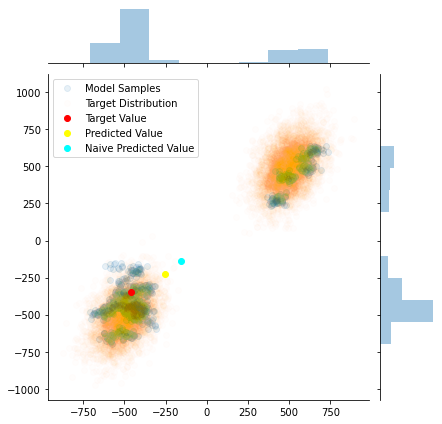

In [21]:
i = np.random.choice(np.arange(y_test.shape[0]))

alpha, beta, gamma = 1,1,0
noise_factor = 1
samples = density_estimator1.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta,gamma = gamma, noise_factor = noise_factor)
prediction = density_estimator1.custom_predict(
    X_test[i:i+1], agg_func = lambda x: np.mean(x,axis = 0), alpha = alpha, beta = beta, gamma = gamma, noise_factor = 1)
naive_prediction = density_estimator1.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

In [22]:
alpha, beta, gamma = 1,1,1
samples1 = density_estimator1.sample(X_test, sample_size = 70, alpha = alpha, beta = beta, gamma = gamma)
kde_entropy(quantile(y_test,samples1)), bimodal_variance(samples1).mean()

Querying 30 nearest neighbors, this can take a while...


(array([2.12855893]), 20786.618095584963)

Querying 30 nearest neighbors, this can take a while...


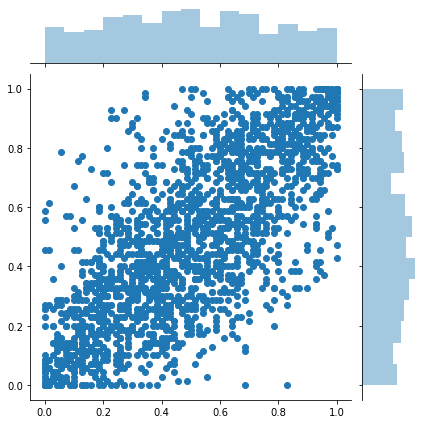

In [23]:
alpha, beta, gamma = 1,1,1
samples1 = density_estimator1.sample(X_test, sample_size = 70, alpha = alpha, beta = beta, gamma = gamma)
sns.jointplot(*quantile(y_test, samples1)[0].T)

## KernelTreeEntropyEstimator- 
#########################################################################################
appart from similarity factor $\alpha$, include node relevance factor $\beta$  in order to have $(\frac{NodeAggMetric}{NodeAggMetric_{max}})^\beta$ as node multipliers in the node - data adjacency matrix. NodeAggMetric could be variance, entropy, or user dfined metric, such as likelihood to some distribution.

then sample according to $CosSim(A,B)^\alpha$

May include KDE sampling for nodes, depending on ammount of nodes

make this framework default for every DensityTree (NaiveTree is a special case for alpha = 0 and beta = 0)

In [24]:
#export
class KernelTreeEntropyEstimator(KernelTreeEstimator):
    '''
    An ensemble that learn representitons of data turning target into bins
    '''
    def __init__(self, estimator, entropy_estimator_sampler = None, resolution = 100, alpha = 1, beta = 1, gamma = 1, node_rank_func = None,
                 node_data_rank_func = None,n_neighbors = 30, lower_bound = 0.0):

        super().__init__(estimator, entropy_estimator_sampler, alpha, beta, gamma, node_rank_func,
                 node_data_rank_func,n_neighbors, lower_bound)

        self.resolution = resolution
        

    def _q_transformer_fit(self, y):
        '''
        fits self.q_transformer
        '''
        y = _fix_X_1d(y)
        if type(self.resolution) == str:            
            self.bin_edges = [np.histogram_bin_edges(col, bins = self.resolution) for col in y.T]
            return self.bin_edges
        
        elif type(self.resolution) == int:
            self.q_transformer = QuantileTransformer(n_quantiles = self.resolution)
            self._q_minmax_scaler = MinMaxScaler()            
            y = self.q_transformer.fit_transform(y)
            #for case when output_distribution != uniform
            self._q_minmax_scaler.fit(y)
            return self.q_transformer
        
        elif isinstance(self.resolution,list):
            return self.resolution
        
        else: raise TypeError(f'self.resolution should be Array of bin edges, str or int, got {self.resolution.__class__}')
        
        

    def _q_transformer_transform(self, y):
        '''
        maps floats to int (bin_id in histogram)
        '''
        y = _fix_X_1d(y)
        
        if type(self.resolution) == str:
            y_transformed = [np.digitize(y[:,i:i+1], self.bin_edges[i]) for i in range(y.shape[-1])]
            y_transformed = np.hstack(y_transformed)
            
        elif type(self.resolution) == int:
            y_transformed = self.q_transformer.transform(y)
            #scale between 0 and 1
            y_transformed = self._q_minmax_scaler.transform(y_transformed)
            y_transformed = np.around(y_transformed*(self.resolution - 1), decimals = 0).astype(int)
        
        elif isinstance(self.resolution, list):
            y_transformed = [np.digitize(y[:,i:i+1], self.resolution[i]) for i in range(y.shape[-1])]
            y_transformed = np.hstack(y_transformed)
        
        return y_transformed

    def _q_transformer_inverse_transform(self,y):
        '''
        maps from bin_id in histogram (int) to float.
        beware that during transform, information is lost due to downsampling, so inverse_transform will
        not be an exact inverse_transform.
        '''
        y = _fix_X_1d(y)
        if type(self.resolution) == int:
            y_transformed = (y/(self.resolution - 1)).astype(float)
            y_transformed = self._q_minmax_scaler.inverse_transform(y_transformed)
            return self.q_transformer.inverse_transform(y_transformed).flatten() #1d asserted already
        else: raise NotImplementedError('inverse transform only implemented for case when self.resolution == int')

    def _preprocess_y(self, y):
        
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        #save y values
        self.y_ = y
        #reshape (-1,1) in case of 1d
        y = _fix_X_1d(y)
        #make uniform quantile bins        
        self._q_transformer_fit(y)
        y = self._q_transformer_transform(y)
        return y
    
    def fit(self, X, y = None, preprocess_y = True, **fit_kws):        
        
        if preprocess_y:
            y = self._preprocess_y(y)
        
        # fit
        self.estimator.fit(X,y, **fit_kws)

        if self.entropy_estimator_sampler is None:
            self._fit_leaf_node_matrix(
                X, self.y_, node_rank_func = self.node_rank_func, node_data_rank_func = self.node_data_rank_func)# <- MAKE NODE WIEGHTED VERSION
        else:
            self._fit_entropy_estimator_sampler(X, y)

        return self

In [25]:
#estimator2 = ensemble.GradientBoostingClassifier(n_estimators = 4,learning_rate = 0.05,min_samples_leaf = 5, subsample = 0.4, max_features = 0.4, verbose = 2,)
estimator2 = ensemble.RandomForestClassifier(n_jobs = -1,n_estimators = 10,min_samples_leaf = 20, warm_start = True, criterion = 'entropy')
estimator1 = ensemble.RandomForestRegressor(n_jobs = -1,n_estimators = 10,min_samples_leaf = 20, warm_start = True, criterion = 'mae')

density_estimator2 = KernelTreeEntropyEstimator(
    estimator2,resolution = 'auto',node_rank_func = 'expected_likelihood', node_data_rank_func = 'kde_likelihood')

#density_estimator2 = JointKernelTreeEstimator(density_estimator2)
density_estimator2.fit(X_train,y_train[:,:])

#density_estimator1 = KernelTreeEstimator(
#    estimator1,node_rank_func = 'expected_likelihood', node_data_rank_func = 'kde_likelihood').fit(X_train,y_train[:,:])

KernelTreeEntropyEstimator

Querying 30 nearest neighbors, this can take a while...



Querying 30 nearest neighbors, this can take a while...


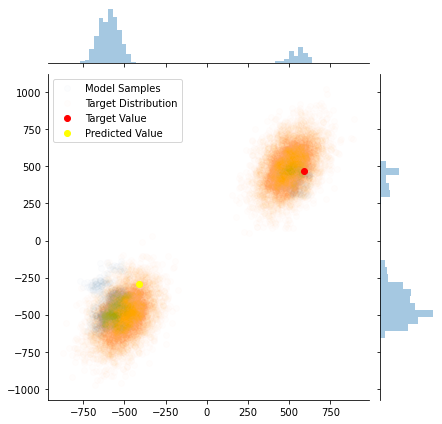

In [26]:
i = np.random.choice(np.arange(y_test.shape[0]))

alpha, beta, gamma = 1,0,0
noise_factor = 1
samples = density_estimator2.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor)
#samples = density_estimator2.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma)
prediction = density_estimator2.custom_predict(X_test[i:i+1],agg_func = lambda x: np.mean(x, axis = 0) ,alpha = alpha, beta = beta, gamma = gamma)
#naive_prediction = density_estimator.estimator.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.01})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    #jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()

In [27]:
alpha, beta, gamma = 1,2,0
noise_factor = 0.2
samples1 = density_estimator1.sample(X_test, sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor)
samples2 = density_estimator2.sample(X_test, sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor)


Querying 30 nearest neighbors, this can take a while...



Querying 30 nearest neighbors, this can take a while...


We can plot the entropies of the distributions and the negative log likelihood of the generated KDE against de actual y_test value

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


-1.8028240422037318 -1.1494187217216616


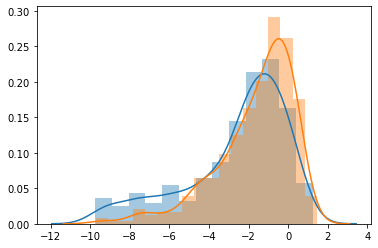

In [28]:
ll1 = np.log2(kde_likelihood(y_test,samples1, frac = 0.2))
ll2 = np.log2(kde_likelihood(y_test,samples2, frac = 0.2))
print(np.median(ll1[ll1 > -10]), np.median(ll2[ll2 > -10]))
sns.distplot(ll1[ll1 > -10])
sns.distplot(ll2[ll2 > -10])

1.194596716055627 1.1442232286993543


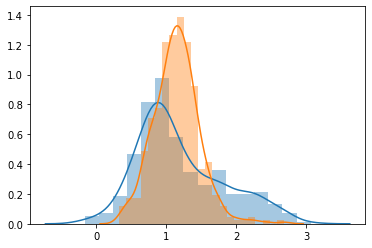

In [29]:
entr1 = kde_entropy(samples1, sample_size = 200 , frac = 0.2)
entr2 = kde_entropy(samples2, sample_size = 200 , frac = 0.2)
print(entr1.mean(),entr2.mean())
sns.distplot(entr1)
sns.distplot(entr2)

(0.8452374928120305, 1.2163135467640347)

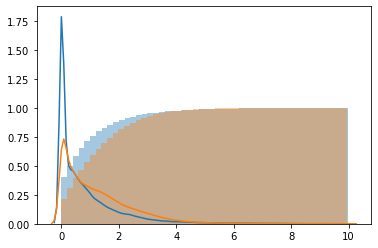

In [30]:
#we want the likelihood of our datapoints to be higher than the average likelihood of the distribution
# so we convert entropy and negative log likelihood  to likelihoods and divide the point likelihood by the average dist likeliihood
t1 = 2**ll1/2**-entr1
t2 = 2**ll2/2**-entr2
sns.distplot(t1[t1 < 10], hist_kws = dict(cumulative = True))
sns.distplot(t2[t2 < 10], hist_kws = dict(cumulative = True))
np.mean(t1[t1 < 1000]),np.mean(t2[t2 < 1000])

In [31]:
q2 = quantile(y_test,samples2)
q1 = quantile(y_test,samples1)

'3.02% of data points out of sugested boundaries'

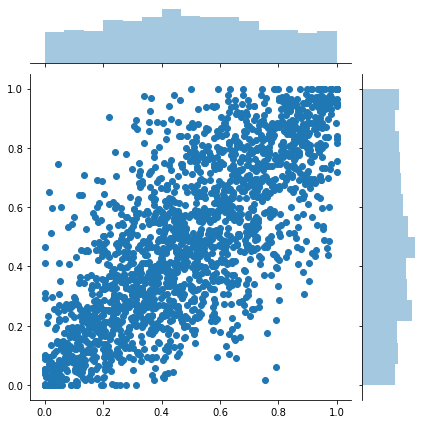

In [32]:
sns.jointplot(q1[0,:,0],q1[0,:,1])
f'{round(((q1 == 0).mean()+(q1 == 1).mean())*100,2)}% of data points out of sugested boundaries'

'1.42% of data points out of sugested boundaries'

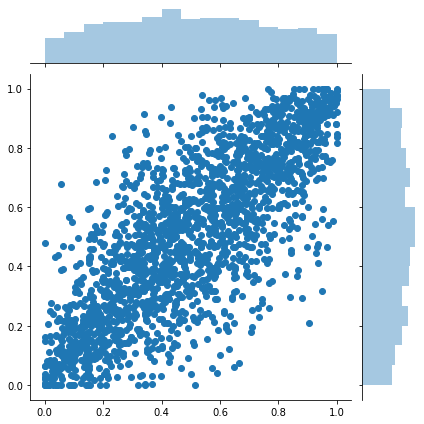

In [33]:
sns.jointplot(q2[0,:,0],q2[0,:,1])
f'{round(((q2 == 0).mean()+(q2 == 1).mean())*100,2)}% of data points out of sugested boundaries'

We can check the estimated KDE of the samples of each model against the y_test(target) distribution and the actual y_test value

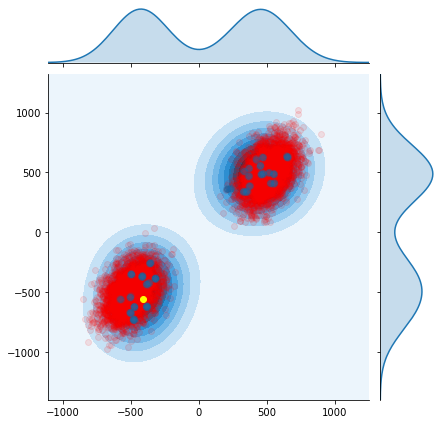

In [34]:
i+=1
kde = KDE().fit(samples1[i])
kde_cloud = kde.sample(100)
jnt = sns.jointplot(kde_cloud[:,0],kde_cloud[:,1], kind = 'kde')
jnt.ax_joint.scatter(density_estimator2.y_[:,0], density_estimator2.y_[:,1], color = 'r', alpha = 0.1)
jnt.ax_joint.scatter(samples1[i,:,0], samples1[i,:,1], alpha = 0.05)
jnt.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'yellow')

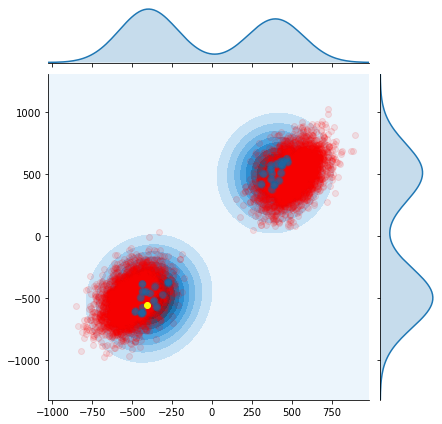

In [35]:
kde = KDE().fit(samples2[i])
kde_cloud = kde.sample(100)
jnt = sns.jointplot(kde_cloud[:,0],kde_cloud[:,1], kind = 'kde')
jnt.ax_joint.scatter(density_estimator2.y_[:,0], density_estimator2.y_[:,1], color = 'r', alpha = 0.1)
jnt.ax_joint.scatter(samples2[i,:,0], samples2[i,:,1], alpha = 0.05)
jnt.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'yellow')

# Joint and Chained Estimators

In [36]:
# export
class JointEntropyEstimator(MultiOutputClassifier):
    '''
    Performs a joint entropy estimation based on stacked model of marginal distribution estimators.
    All the marginal distributions are merged using a KernelTreeEntropyEstimator, that nativelly supports
    joint estimation
    '''
    def __init__(self, estimator, resolution = 20, joint_estimator=None, stacking_method='auto', n_jobs=None):
        assert hasattr(
            estimator, 'predict_proba'), 'Estimator should have `predict_proba` method'
        super().__init__(estimator, n_jobs)
        if joint_estimator is None:
            rf = ensemble.RandomForestClassifier(
                n_estimators=20, min_samples_leaf=10, )
            self.joint_estimator = KernelTreeEntropyEstimator(
                rf, resolution=resolution)
        else:
            assert isinstance(
                joint_estimator, KernelTreeEntropyEstimator), 'joint_estimator should be instance of KernelTreeEntropyEstimator'
            self.joint_estimator = joint_estimator

        self.stacking_method = stacking_method                
        self.resolution = resolution
        return

    def _make_stacked_predictors(self, X, stacking_method):

        if stacking_method == 'auto':
            attr_hierarchy = (
                'predict_proba', 'decision_function', 'predict', 'transform')
            predictors = []
            for estim in self.estimators_:
                passed = False
                for attr in attr_hierarchy:
                    if hasattr(estim, attr):
                        predictors.append(getattr(estim, attr)(X))
                        passed = True
                        break
                if passed == False:
                    raise AttributeError(
                        f'{estim} does not have any of these methods: {attr_hierarchy}')
        else:
            predictors = [getattr(estim, stacking_method)(X)
                          for estim in self.estimators_]

        return np.hstack(predictors)

    def fit(self, X, y=None, sample_weight=None):        
        y = self.joint_estimator._preprocess_y(y)        
        super().fit(X, y, sample_weight)
        marginal_results = self._make_stacked_predictors(
            X, self.stacking_method)
        self.joint_estimator.fit(marginal_results, y, preprocess_y = False)
        return self

    def sample(self, X, sample_size=10, weight_func=None, n_neighbors=None, lower_bound=None,
               alpha=None, beta=None, gamma=None, noise_factor=0,):

        marginal_results = self._make_stacked_predictors(
            X, self.stacking_method)

        return self.joint_estimator.sample(marginal_results, sample_size, weight_func, n_neighbors, lower_bound,
                                           alpha, beta, gamma, noise_factor,)

    def density(self, X, dist='kde', sample_size=10, weight_func=None, n_neighbors=None, lower_bound=None,
                alpha=None, beta=None, gamma=None, noise_factor=1e-07, **dist_kwargs,):

        marginal_results = self._make_stacked_predictors(
            X, self.stacking_method)

        return self.joint_estimator.density(marginal_results, dist, sample_size, weight_func, n_neighbors, lower_bound,
                                            alpha, beta, gamma, noise_factor, **dist_kwargs,)

    def custom_predict(self, X, agg_func, sample_size=100, weights=None, n_neighbors=None,
                       lower_bound=None, alpha=None, beta=None, gamma=None, noise_factor=0,):

        marginal_results = self._make_stacked_predictors(
            X, self.stacking_method)

        return self.joint_estimator.custom_predict(marginal_results, agg_func, sample_size, weights,
                                                   n_neighbors, lower_bound, alpha, beta, gamma, noise_factor,)


class ChainedEntropyEstimator():
    '''
    make chained joint estimator based on previous estimations
    there are three ways to pass predictors to next estimator in the chain:
    pass only predictions from previous estimator based on stacking_method
    pass predictions from all previous estimators based on stacking_method
    pass predictions from all previous estimators based on stacking_method and also the features used in all estimators
    
    '''
    def __init__(self):
        raise NotImplementedError('ChainedEntropyEstimator is not implemented yet')
    
    
class JointKernelTreeEstimator(MultiOutputRegressor):

    '''Custom multioutput for multioutput estimator for `KernelTreeEstimator`s'''

    @property
    def y_(self,):
        '''stacked y_ attributes of each estimator (one for each dim)'''
        return np.hstack([_fix_X_1d(estim.y_) for estim in self.estimators_])

    def _similarity_sample_idx(self, X, sample_size=100, weights=None, n_neighbors=10,
                               lower_bound=0.0, alpha=1, beta=0, gamma=0):

        sampled_idxs = np.hstack([
            _fix_X_1d(estim._similarity_sample_idx(X, sample_size, weights, n_neighbors,
                                                   lower_bound, alpha, beta, gamma)
                      ) for estim in tqdm(self.estimators_)
        ])

        return sampled_idxs

    def sample(self, X, sample_size=100, weights=None, n_neighbors=10,
               lower_bound=0.0, alpha=1, beta=0, gamma=0, noise_factor=0):

        idxs = self._similarity_sample_idx(
            X, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma)

        samples = self.y_[[idx for idx in idxs]]
        # fix ndim if sampling for a single value (1, n_samples, n_dims) instead of (n_samples, n_dims)
        samples = samples if len(
            samples.shape) != 2 else _add_n_dists_axis(samples)
        # samples will have n_dims*sample_size samples, resample with no replacement to match sample_size
        samples = sample_from_dist_array(
            samples, sample_size=sample_size, weights=None, replace=False)
        # define noise to be added
        noise = agg_smallest_distance(samples, agg_func=np.std)
        noise = _add_n_samples_axis(noise)
        print(noise.shape, samples.shape)
        return add_noise(samples, noise_factor*noise)

    def custom_predict(self, X, agg_func, sample_size=100, weights=None, n_neighbors=10,
                       lower_bound=0.0, alpha=1, beta=0, gamma=0, noise_factor=0):

        samples = self.sample(X, sample_size, weights, n_neighbors,
                              lower_bound, alpha, beta, gamma, noise_factor)

        return np.array([agg_func(sample) for sample in samples])

In [37]:
base_estim = LogisticRegression(tol = 0.001, solver = 'sag')
joint_estim = JointEntropyEstimator(base_estim, resolution = 'auto')
joint_estim.fit(X_train, y_train[:,:])

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_jobs=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


JointEntropyEstimator(estimator=LogisticRegression(solver='sag', tol=0.001),
                      ('joint_estimator', KernelTreeEntropyEstimator),
                      resolution='auto')

Querying 30 nearest neighbors, this can take a while...



Querying 30 nearest neighbors, this can take a while...


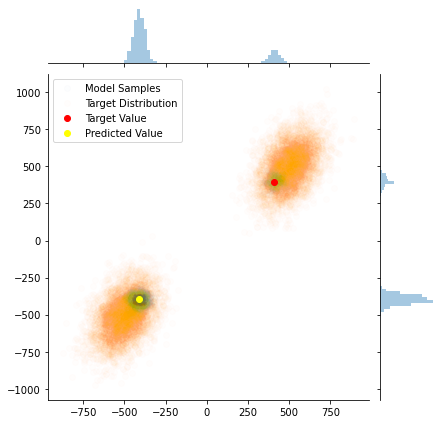

In [38]:
i = np.random.choice(np.arange(y_test.shape[0]))

alpha, beta, gamma = 1,0,0
noise_factor = 1
samples = joint_estim.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor)
#samples = density_estimator2.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma)
prediction = joint_estim.custom_predict(X_test[i:i+1],agg_func = lambda x: np.median(x, axis = 0) ,alpha = alpha, beta = beta, gamma = gamma)
#naive_prediction = density_estimator.estimator.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.01})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    #jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()

# Export -

In [39]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.
Converted 04_metrics.ipynb.
Converted 05_neighbors.ipynb.
Converted 06_kde_baesyan_nets.ipynb.
Converted index.ipynb.
